# Chapter 10: Introduction to Artificial Neural Networks with Keras

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras_tuner as kt

1. [TensorFlow playground](https://playground.tensorflow.org/)

2. Drawing of original ANN (as in figure 10-3) that computes, XOR: $A\oplus B$. Assuming that a neuron is activated when $\geq 2$ of its input connections are active.

<img width="20%" src="datasets/IMG_B049F35CA3D0-1.jpeg"/><img width="20%" src="datasets/IMG_BBB9A8B61AFF-1.jpeg"/>

3. Logistic regression & a classic perceptron, made up of a single layer of threshold logic units (LTUs), function very similarly as classifiers. They differ in two regards:
    * Logistic regression uses the sigmoid activation function (or softmax), whereas the perceptron uses a step function. The sigmoid has the benefit of outputting a probability rather than a 1 or 0. It also has a non-zero gradient, which means it can be trained via gradient descent.
    * They also differ by their training algorithms. The perceptron training algorithm (a.k.a. Hebian learning) will only converge if the training instances are linearly separable, whereas gradient descent (or SGD) will.

4. The sigmoid (or any non-linear) activation function is a key ingredient in training MLPs because it has a non-zero gradient. Meaning MLPs can be trained via gradient descent.

5. Sigmoid, Hyperbolic tan, & Rectified Linear Unit are all popular activation functions.

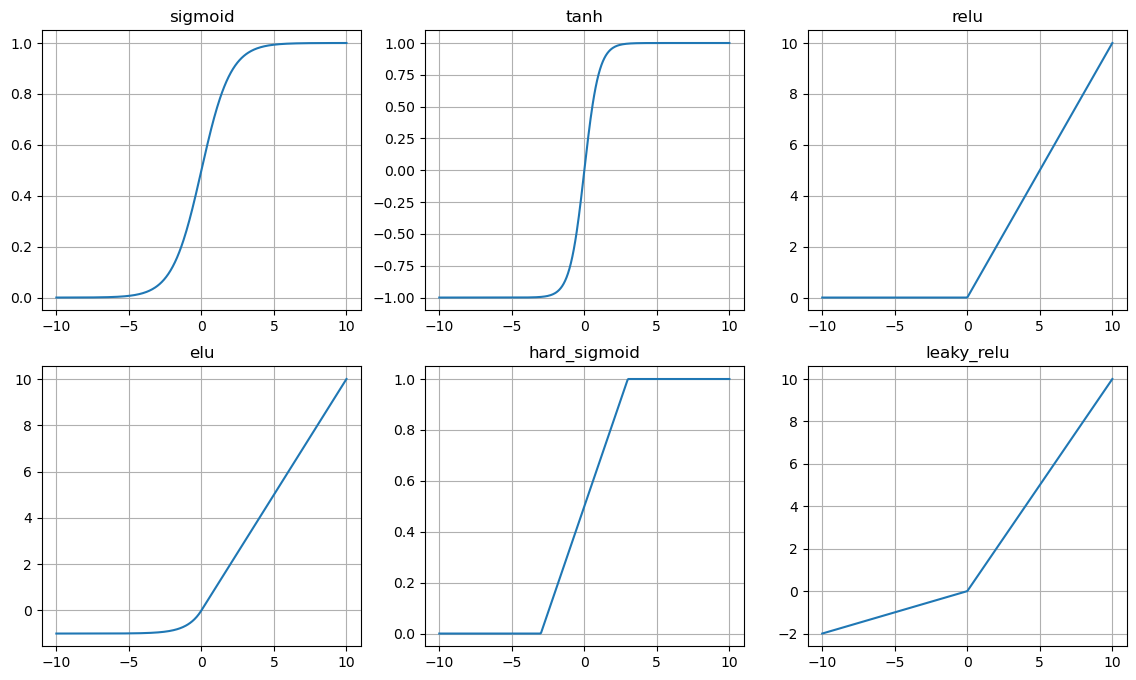

In [2]:
activations = [
    tf.keras.activations.sigmoid,
    tf.keras.activations.tanh,
    tf.keras.activations.relu,
    tf.keras.activations.elu,
    tf.keras.activations.hard_sigmoid,
    tf.keras.activations.leaky_relu,
]

fig, axs = plt.subplots(
    np.ceil(len(activations) / 3).astype(int),
    3,
    figsize=(14, 4 * np.ceil(len(activations) / 3).astype(int)),
)

x = np.linspace(-10, 10, 400)
for i, func in enumerate(activations):
    axs[i // 3, i % 3].plot(x, func(x))
    axs[i // 3, i % 3].set_title(func.__name__)
    axs[i // 3, i % 3].grid(True)

plt.show()

6. Suppose you have an MLP composed of one input layer with 10 passthrough neurons, followed by one hidden layer with 50 artificial neurons, and finally one output layer with 3 artificial neurons. All artificial neurons use the ReLU activation function.
    * a) X.shape = (m, 10) where m is the number of instances
    * b) W_h.shape = (10, 50) & b_h = (50,)
    * c) W_o.shape = (50, 3) & b_o = (3,)
    * d) Y.shape = (m, 3)
    * e) $Y = ReLU(ReLU(XW_h + b_h)W_o + b_o)$
7. Classifying emails into ham and spam is binary classification since the classes are mutually exclusive. 
    * Therefore only **one output neuron** is required, 
    * **sigmoid** would be a good choice for output layer activation since it outputs values between 0 & 1. 

    MNIST is a multiclass classification problem, therefore:
    * you need one output neuron per class, i.e. **10**,
    * **softmax** is an ideal activation function for the output as this returns a probability distribution over the 10 values.

    For predicting housing prices, this is a regression problem,
    * you only need **one output neuron** since you are only predicting one value, and
    * **ReLU** would make sense as it only outputs positive values (passthrough would also work).

8. Backpropagation is how neural networks calculate the gradient of the cost function with respect to the model parameters via the chain rule. Reverse-mode autodiff is the highly computationally efficient method used to calculate the partial derivatives (not just in ANNs).

9. Hyperparameters of a ANN include: **number of hidden layers**, **size of each of the hidden layers**, the **activation function** of each layer, the learning rate, and batch size. If the model is overfitting you should decrease the number of hidden layers & their size, another effective approach is to use early stopping (a.k.a. shrinking the oversized trousers).

## 10. Training an MLP for the MNIST dataset

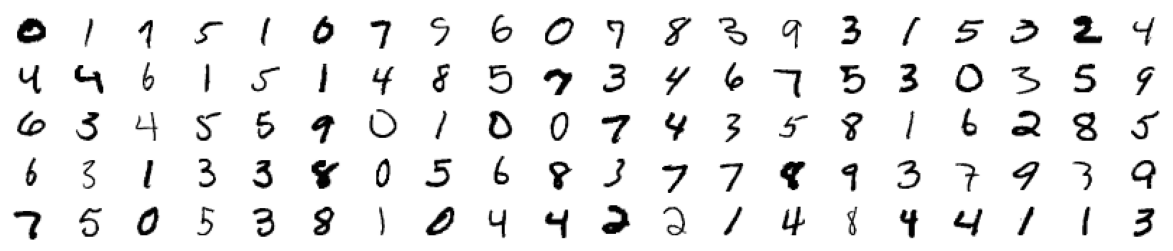

X_train shape: (50000, 28, 28)
y_train shape: (50000,)

X_val shape: (10000, 28, 28)
y_val shape: (10000,)

X_test shape: (10000, 28, 28)
y_test shape: (10000,)


In [3]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=10_000, stratify=y_train
)

fig, axs = plt.subplots(5, 20, figsize=(15, 3))
for ax, digit in zip(axs.flatten(), X_train[:100]):
    ax.imshow(digit, cmap="binary")
    ax.axis("off")
plt.show()

print(
    f"X_train shape: {X_train.shape}",
    f"y_train shape: {y_train.shape}\n",
    f"X_val shape: {X_val.shape}",
    f"y_val shape: {y_val.shape}\n",
    f"X_test shape: {X_test.shape}",
    f"y_test shape: {y_test.shape}",
    sep="\n",
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 28, 28)         │            57 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 125)            │        98,125 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 125)            │        15,750 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 125)            │        15,750 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 125)            │        15,750 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │         1,260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 146,692 (573.02 KB)

 Trainable params: 146,635 (572.79 KB)

 Non-trainable params: 57 (232.00 B)

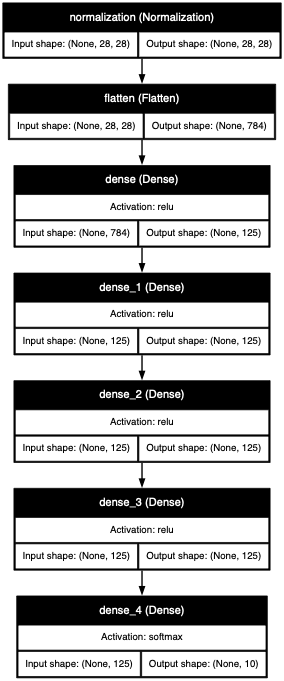

In [4]:
def make_model():
    tf.keras.backend.clear_session()  # resets the layer naming

    norm_layer = tf.keras.layers.Normalization()
    norm_layer.adapt(X_train)

    model = tf.keras.Sequential(
        [
            tf.keras.layers.Input((28, 28)),
            norm_layer,
            tf.keras.layers.Flatten(name="flatten"),
            tf.keras.layers.Dense(125, activation="relu"),
            tf.keras.layers.Dense(125, activation="relu"),
            tf.keras.layers.Dense(125, activation="relu"),
            tf.keras.layers.Dense(125, activation="relu"),
            tf.keras.layers.Dense(10, activation="softmax"),
        ]
    )

    model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=tf.keras.optimizers.Adam(),
        metrics=["accuracy"],
    )

    return model


model = make_model()
model.summary()

tf.keras.utils.plot_model(
    model,
    to_file="models/10_MNIST_MLP.png",
    show_layer_names=True,
    show_shapes=True,
    show_layer_activations=True,
    dpi=50,
)

### Creating a custom callback to find the optimal learning rate

In [5]:
class ExponentialLearningRate(tf.keras.callbacks.Callback):
    def __init__(self, starting_lr, end_lr, n_iter):
        self.factor = (end_lr / starting_lr) ** (1 / n_iter)
        self.starting_lr = starting_lr
        self.end_lr = end_lr
        self.learning_rates = []
        self.losses = []

    def on_train_begin(self, logs=None):
        self.model.optimizer.learning_rate = self.starting_lr

    def on_train_batch_end(self, batch, logs=None):
        lr = self.model.optimizer.learning_rate.numpy() * self.factor
        if lr > self.end_lr:
            self.model.stop_training = True

        self.model.optimizer.learning_rate = lr
        self.learning_rates.append(lr)
        self.losses.append(logs["loss"])


exponential_learning_rate = ExponentialLearningRate(1e-5, 1e-1, 5_000)

history = model.fit(
    X_train,
    y_train,
    epochs=5,
    validation_data=(X_val, y_val),
    callbacks=[exponential_learning_rate],
)

Epoch 1/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.4343 - loss: 1.7490 - val_accuracy: 0.9163 - val_loss: 0.2809
Epoch 2/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9263 - loss: 0.2454 - val_accuracy: 0.9128 - val_loss: 0.3009
Epoch 3/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8286 - loss: 0.5725 - val_accuracy: 0.1124 - val_loss: 2.3053
Epoch 4/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 466us/step - accuracy: 0.1064 - loss: 2.3107 - val_accuracy: 0.1124 - val_loss: 2.3273


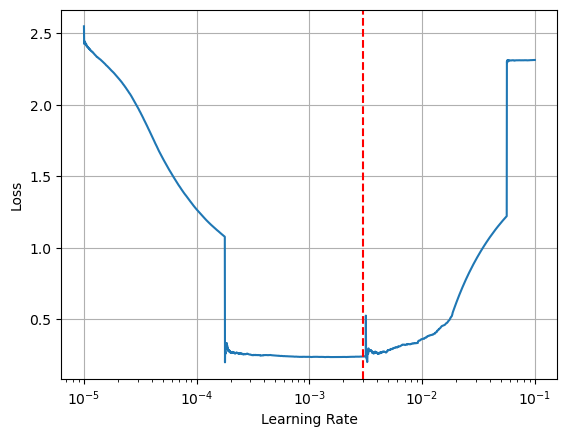

In [6]:
fig, ax = plt.subplots()

ax.plot(exponential_learning_rate.learning_rates, exponential_learning_rate.losses)
ax.axvline(x=0.003, color="r", linestyle="--")
ax.set_xscale("log")
ax.set_xlabel("Learning Rate")
ax.set_ylabel("Loss")
ax.grid(True)

plt.show()

From the left hand plot we see that the loss starts to rise again at a learning rate of **0.003**, therefore I set the learning rate to 10 times lower that, before retraining the model.

In [7]:
model = make_model()

model.optimizer.learning_rate = 3e-4

early_stopping = tf.keras.callbacks.EarlyStopping(
    verbose=1,
    patience=3,
    restore_best_weights=True,
)

history = model.fit(
    X_train,
    y_train,
    epochs=50,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
)

Epoch 1/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8234 - loss: 0.5679 - val_accuracy: 0.9472 - val_loss: 0.1709
Epoch 2/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9619 - loss: 0.1219 - val_accuracy: 0.9551 - val_loss: 0.1420
Epoch 3/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9758 - loss: 0.0783 - val_accuracy: 0.9644 - val_loss: 0.1294
Epoch 4/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9828 - loss: 0.0549 - val_accuracy: 0.9635 - val_loss: 0.1301
Epoch 5/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9874 - loss: 0.0410 - val_accuracy: 0.9640 - val_loss: 0.1288
Epoch 6/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9903 - loss: 0.0322 - val_accuracy: 0.9672 - val_loss: 0.1350
Epoch 7/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9910 - loss: 0.0274 - val_accuracy: 0.9700 - val_loss: 0.1313
Epoch 8/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9931 - loss: 0.0213 - 

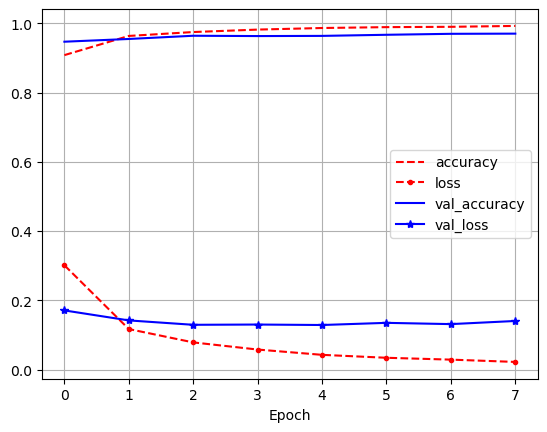

In [8]:
pd.DataFrame(history.history).plot(
    grid=True,
    xlabel="Epoch",
    style=["r--", "r--.", "b-", "b-*"],
)
plt.show()

In [9]:
model.evaluate(X_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 668us/step - accuracy: 0.9608 - loss: 0.1437


[0.12371625006198883, 0.9670000076293945]

### Using Keras Tuner & TensorBoard

In [10]:
%load_ext tensorboard
%tensorboard --logdir=models/10/

In [11]:
tf.keras.backend.clear_session()  # resets the layer naming


def build_model(hyper_params):
    num_hidden_layers = hyper_params.Int(
        "num_hidden_layers", min_value=2, max_value=10, default=4
    )
    num_neurons = hyper_params.Int(
        "num_neurons", min_value=16, max_value=512, default=125
    )
    learning_rate = hyper_params.Float(
        "learning_rate", min_value=1e-5, max_value=1e-2, default=3e-4, sampling="log"
    )
    optimizer = hyper_params.Choice("optimizer", values=["sgd", "adam"])
    activation = hyper_params.Choice("activation", values=["relu", "tanh", "sigmoid"])

    model = tf.keras.Sequential()

    model.add(tf.keras.layers.Input((28, 28)))
    norm_layer = tf.keras.layers.Normalization()
    norm_layer.adapt(X_train)
    model.add(norm_layer)
    model.add(tf.keras.layers.Flatten(name="flatten"))
    for _ in range(num_hidden_layers):
        model.add(tf.keras.layers.Dense(num_neurons, activation=activation))
    model.add(tf.keras.layers.Dense(10, activation="softmax"))

    if optimizer == "sgd":
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    elif optimizer == "adam":
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        print("ERROR: no optimizer set")
        return

    model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=optimizer,
        metrics=["accuracy"],
    )

    return model


hyperband_tuner = kt.Hyperband(
    build_model,
    objective="val_accuracy",
    max_epochs=10,
    factor=5,
    hyperband_iterations=4,
    overwrite=True,
    directory="models/10/hyperband_tuning",
    project_name="hyperband_tuning",
)


tensorboard_cb = tf.keras.callbacks.TensorBoard(
    "models/10/hyperband_tuning/tensorboard"
)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    verbose=1,
    patience=5,
    restore_best_weights=True,
)

hyperband_tuner.search(
    X_train[:10_000],
    y_train[:10_000],
    validation_data=(X_val, y_val),
    callbacks=[tensorboard_cb, early_stopping_cb],
)

Trial 52 Complete [00h 00m 37s]
val_accuracy: 0.9380000233650208

Best val_accuracy So Far: 0.9567999839782715
Total elapsed time: 00h 07m 25s


In [12]:
hyperband_tuner.get_best_hyperparameters()[0].values

{'num_hidden_layers': 2,
 'num_neurons': 396,
 'learning_rate': 0.0008003793838164983,
 'optimizer': 'adam',
 'activation': 'relu',
 'tuner/epochs': 10,
 'tuner/initial_epoch': 2,
 'tuner/bracket': 1,
 'tuner/round': 1,
 'tuner/trial_id': '0004'}

### Retraining a model with the best hyper parameters

In [13]:
model = build_model(hyperband_tuner.get_best_hyperparameters()[0])

tensorboard_cb = tf.keras.callbacks.TensorBoard(
    "models/10/tuned_hyper_params_refit/tensorboard"
)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    verbose=1,
    patience=10,
    restore_best_weights=True,
)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "models/10/tuned_hyper_params_refit/model.weights.h5",
    save_best_only=True,
    save_weights_only=True,
)

history = model.fit(
    X_train,
    y_train,
    epochs=50,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping_cb, checkpoint_cb, tensorboard_cb],
)

Epoch 1/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9003 - loss: 0.3292 - val_accuracy: 0.9624 - val_loss: 0.1468
Epoch 2/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9738 - loss: 0.0887 - val_accuracy: 0.9648 - val_loss: 0.1286
Epoch 3/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9813 - loss: 0.0589 - val_accuracy: 0.9696 - val_loss: 0.1191
Epoch 4/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9882 - loss: 0.0370 - val_accuracy: 0.9690 - val_loss: 0.1144
Epoch 5/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9904 - loss: 0.0305 - val_accuracy: 0.9712 - val_loss: 0.1325
Epoch 6/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9921 - loss: 0.0258 - val_accuracy: 0.9720 - val_loss: 0.1335
Epoch 7/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9932 - loss: 0.0232 - val_accuracy: 0.9720 - val_loss: 0.1283
Epoch 8/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9944 - loss: 0.0182 - 

In [14]:
model.evaluate(X_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step - accuracy: 0.9622 - loss: 0.1488


[0.13040661811828613, 0.9674999713897705]

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 671us/step
Misclassified 325/10,000 digits in the test set.


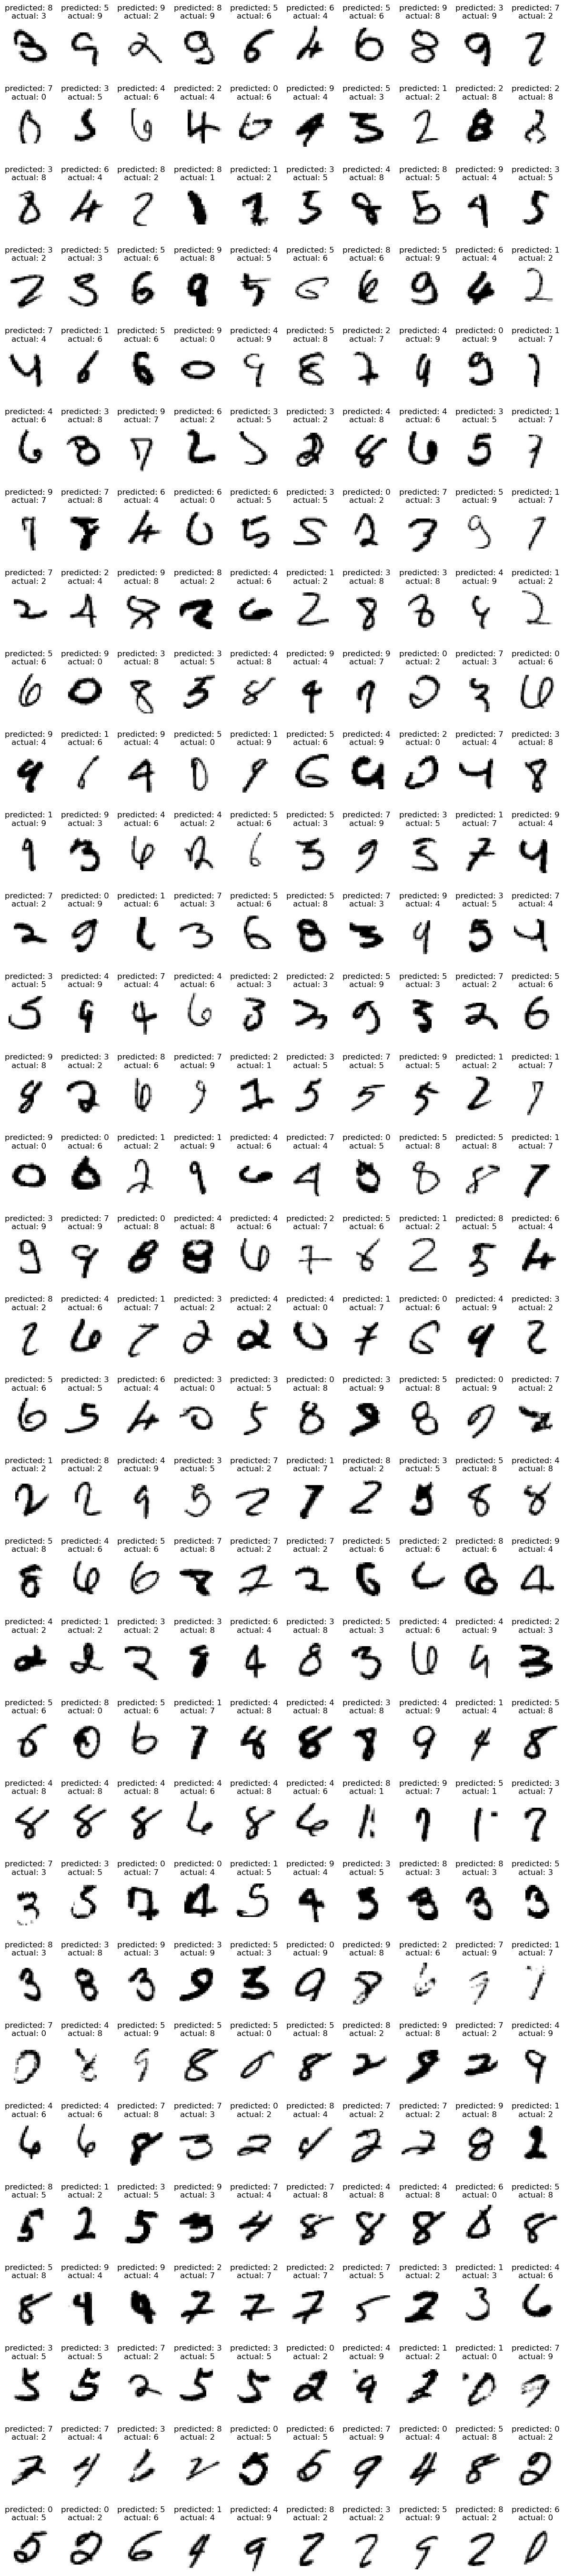

In [21]:
y_pred = model.predict(X_test).argmax(axis=-1)
misclassified_mask = y_pred != y_test
misclassified_digits = X_test[misclassified_mask]

print(
    f"Misclassified {sum(misclassified_mask):,}/{X_test.shape[0]:,} digits in the test set."
)

fig, axs = plt.subplots(sum(misclassified_mask) // 10, 10, figsize=(15, 70))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(misclassified_digits[i], cmap="binary")
    ax.set_title(
        f"predicted: {y_pred[misclassified_mask][i]}\nactual: {y_test[misclassified_mask][i]}"
    )
    ax.axis("off")
plt.show()